In [2]:
import base64
import datetime
import json
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image

In [3]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [4]:
check_openai_version()


Installed OpenAI version: 1.13.3
[OK] OpenAI version 1.13.3 is >= 1.0.0


In [14]:
load_dotenv(".env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")

In [6]:
model = "viz"  # This is the deployed name of your GPT4 Vision model from the Azure Open AI studio


In [7]:
def image_view(image_file):
    """
    View image
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)

./extracted_stamps/Yale-HOT-StudentForm-StampExample1.png


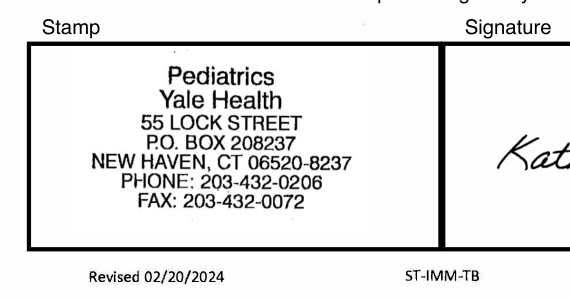

In [8]:
image_view('./extracted_stamps/Yale-HOT-StudentForm-StampExample1.png')

In [29]:
from tenacity import retry, stop_after_attempt, wait_fixed 


@retry(wait=wait_fixed(35), stop=stop_after_attempt(3))
def gpt4V(image_file):
    """
    GPT4-Vision
    """
    # Checking if file exists
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    # Endpoint
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    gpt4vision_endpoint = f"{base_url}/chat/completions?api-version=2023-12-01-preview"

    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded image
    base_64_encoded_image = base64.b64encode(open(image_file, "rb").read()).decode(
        "ascii"
    )

    context = """ 
    You are a administrative assistant capable of reviewing images of medical forms.
    A user uploads an image and asks you whether it contains a doctor stamp or not
    """

    prompt = """
    You respond with yes or no, don't provide any other information.
    The output should only be 'Yes' if the image contains a doctor stamp, and 'No' if it does not.
    """

    # Prompt
    json_data = {
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": [prompt, {"image": base_64_encoded_image}]},
        ],
        "max_tokens": 4000,
        "temperature": 0.7,
    }

    # Results
    response = requests.post(
        gpt4vision_endpoint, headers=headers, data=json.dumps(json_data)
    )

    if response.status_code == 200:
        now = str(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))
        print(f"Analysis of image: {image_file}")
        resp = json.loads(response.text)["choices"][0]["message"]["content"]
        print(resp)
        return resp
        

    elif response.status_code == 429:
        print(
           response.text
        )
        raise Exception("Too many requests. Please wait and try again.")

    else:
        print("[Error] Error code:", response.status_code)

In [17]:
gpt4V('./extracted_stamps/Yale-HOT-StudentForm-StampExample1.png')

Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-StampExample1.png
Yes


In [28]:
import os
import pandas as pd

folder_path = './extracted_stamps'

file_paths = []
stamps = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path)
        if 'NotAStampExample' in file_path:
            stamps.append(1)
        else:
            stamps.append(0)

df = pd.DataFrame({'file_path': file_paths, 'stamp': stamps})

df.head()

,file_path,stamp
0,./extracted_stamps/Yale-HOT-StudentForm-StampE...,0
1,./extracted_stamps/Yale-HOT-StudentForm-NotASt...,1
2,./extracted_stamps/Yale-HOT-StudentForm-StampE...,0
3,./extracted_stamps/Yale-HOT-StudentForm-NotASt...,1
4,./extracted_stamps/Yale-HOT-StudentForm-NotASt...,1


In [30]:
df['prediction'] = df['file_path'].apply(gpt4V).replace({'Yes': 1, 'No': 0})

Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-StampExample2.png
Yes
Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-NotAStampExample5.png
No
Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-StampExample14.png
Yes
Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-NotAStampExample6.png
No
Analysis of image: ./extracted_stamps/Yale-HOT-StudentForm-NotAStampExample2.png
No
{"error":{"code":"429","message": "Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2023-12-01-preview have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 45 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit."}}
{"error":{"code":"429","message": "Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2023-12-01-preview have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 9 seconds. 

/tmp/ipykernel_116321/899277341.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['prediction'] = df['file_path'].apply(gpt4V).replace({'Yes': 1, 'No': 0})


In [32]:
df['prediction'] = abs(df['prediction']-1)

In [33]:
df['correct'] = df['stamp'] == df['prediction']

In [35]:
accuracy = df['correct'].mean()
print(f'Accuracy over {len(df)} test images: {accuracy:.2f}')

Accuracy over 39 test images: 0.92


Error in ./extracted_stamps/Yale-HOT-StudentForm-StampExample20.png
./extracted_stamps/Yale-HOT-StudentForm-StampExample20.png


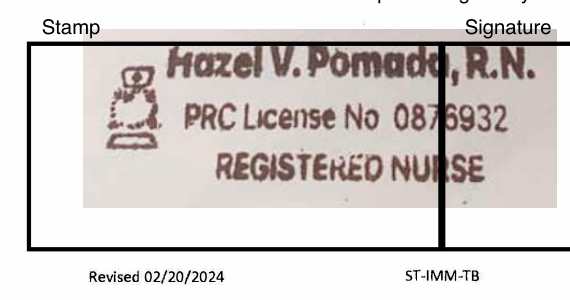

Error in ./extracted_stamps/Yale-HOT-StudentForm-StampExample3.png
./extracted_stamps/Yale-HOT-StudentForm-StampExample3.png


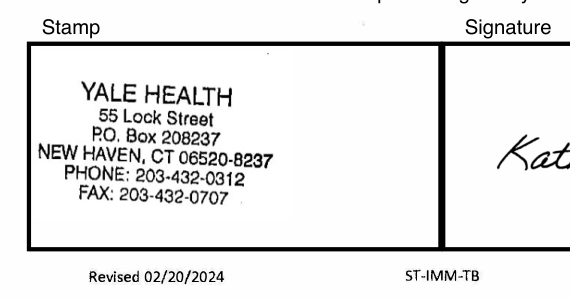

Error in ./extracted_stamps/Yale-HOT-StudentForm-StampExample4.png
./extracted_stamps/Yale-HOT-StudentForm-StampExample4.png


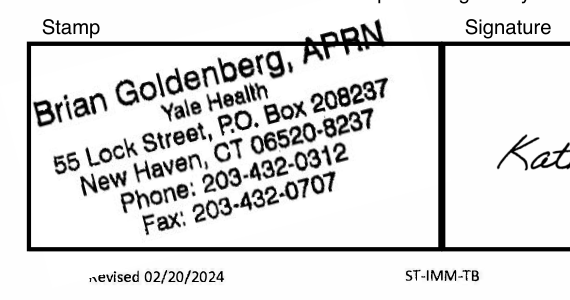

In [36]:
errors =df[~df['correct']]

for i, row in errors.iterrows():
    print(f'Error in {row["file_path"]}')
    image_view(row['file_path'])